In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from tqdm import tqdm
from google.colab import drive
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import f1_score
from scipy.stats import probplot

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Uber-Lyft/rideshare_kaggle.csv')

%matplotlib inline


#Net IDs
# Shruthi N Ganesh	sg2057
# Nikitha Sunku	ns1590
# Vijay Sivakumar	vs851
# Nikita A. Patil	np1010
# Udit Goel	ug42


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:

df.shape

(693071, 57)

In [96]:
df.head()
df['price']

0          5.0
1         11.0
2          7.0
3         26.0
4          9.0
          ... 
693066    13.0
693067     9.5
693068     NaN
693069    27.0
693070    10.0
Name: price, Length: 693071, dtype: float64


# Data Cleaning


In [97]:
df.isnull().sum()

id                                 0
timestamp                          0
hour                               0
day                                0
month                              0
datetime                           0
timezone                           0
source                             0
destination                        0
cab_type                           0
product_id                         0
name                               0
price                          55095
distance                           0
surge_multiplier                   0
latitude                           0
longitude                          0
temperature                        0
apparentTemperature                0
short_summary                      0
long_summary                       0
precipIntensity                    0
precipProbability                  0
humidity                           0
windSpeed                          0
windGust                           0
windGustTime                       0
v

In [98]:
df.dropna(axis=0,inplace=True)

In [99]:
df.isnull().sum()

id                             0
timestamp                      0
hour                           0
day                            0
month                          0
datetime                       0
timezone                       0
source                         0
destination                    0
cab_type                       0
product_id                     0
name                           0
price                          0
distance                       0
surge_multiplier               0
latitude                       0
longitude                      0
temperature                    0
apparentTemperature            0
short_summary                  0
long_summary                   0
precipIntensity                0
precipProbability              0
humidity                       0
windSpeed                      0
windGust                       0
windGustTime                   0
visibility                     0
temperatureHigh                0
temperatureHighTime            0
temperatur

In [100]:
duplicateRows = df[df.duplicated()]
duplicateRows

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime


**Calculating VIF for feature selection**:

In [101]:
# og_cols  = [i for i in df.columns]

# Adding a constant for VIF calculation
X = add_constant(df.select_dtypes(include=[np.number]).dropna())

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in tqdm(range(X.shape[1]))]

# Display the VIF data
print(vif_data)




  0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
100%|██████████| 47/47 [05:34<00:00,  7.11s/it]

                        feature           VIF
0                         const  0.000000e+00
1                     timestamp  4.447786e+05
2                          hour  5.900766e+02
3                           day  6.981063e+05
4                         month  1.528996e+06
5                         price  1.208808e+00
6                      distance  1.139914e+00
7              surge_multiplier  1.065698e+00
8                      latitude  6.511429e+00
9                     longitude  2.347308e+00
10                  temperature  6.892170e+02
11          apparentTemperature  1.155553e+02
12              precipIntensity  5.208862e+00
13            precipProbability  6.961462e+00
14                     humidity  2.816832e+02
15                    windSpeed  2.767699e+01
16                     windGust  1.686844e+01
17                 windGustTime  2.034361e+04
18                   visibility  1.409577e+13
19              temperatureHigh  1.086686e+05
20          temperatureHighTime  2

In [143]:
vif_data = df[["price", "distance", "surge_multiplier", "latitude", "longitude", "precipIntensity", "precipProbability", "windBearing" ,"cloudCover", "cab_type", "name" ]]

vif_data['price'].shape

(637976,)

In [103]:
df['visibility'].equals(df['visibility.1'])
#Checking for duplicate columns

True

In [104]:
df = df.drop(['visibility.1'],axis=1)
#Dropping the duplicate columns

In [105]:
# df.info()

item_counts = df["month"].value_counts()
item_counts


12    374205
11    263771
Name: month, dtype: int64

In [106]:
df['datetime']=pd.to_datetime(df['datetime'])
df.shape

(637976, 56)

### **Exploratory data analysis**

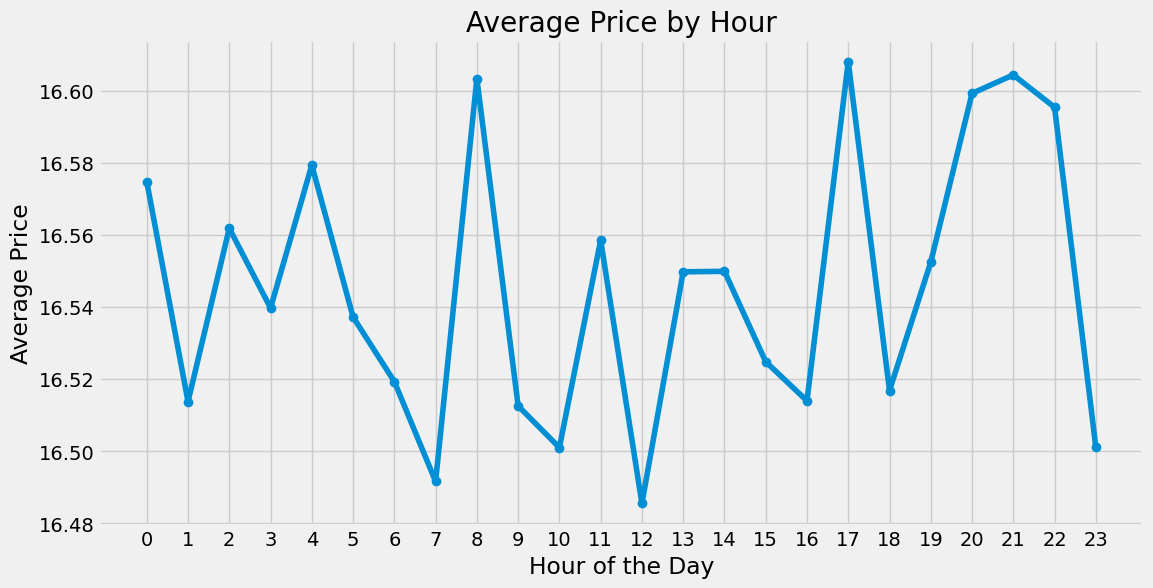

In [107]:
rideshare_df = df
# Convert timestamp to datetime
rideshare_df['timestamp'] = pd.to_datetime(rideshare_df['timestamp'], unit='s')

# Extract hour from timestamp
rideshare_df['hour'] = rideshare_df['timestamp'].dt.hour

# Calculate the average price for each hour
average_price_by_hour = rideshare_df.groupby('hour')['price'].mean()

# Plot the average price against every hour
plt.figure(figsize=(12, 6))
plt.plot(average_price_by_hour.index, average_price_by_hour.values, marker='o', linestyle='-')
plt.title('Average Price by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Price')
plt.xticks(range(24))
plt.grid(True)
plt.show()

<ipython-input-108-e9253a6312c0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyft_data['Time of Day'] = lyft_data['hour'].apply(assign_time_of_day)


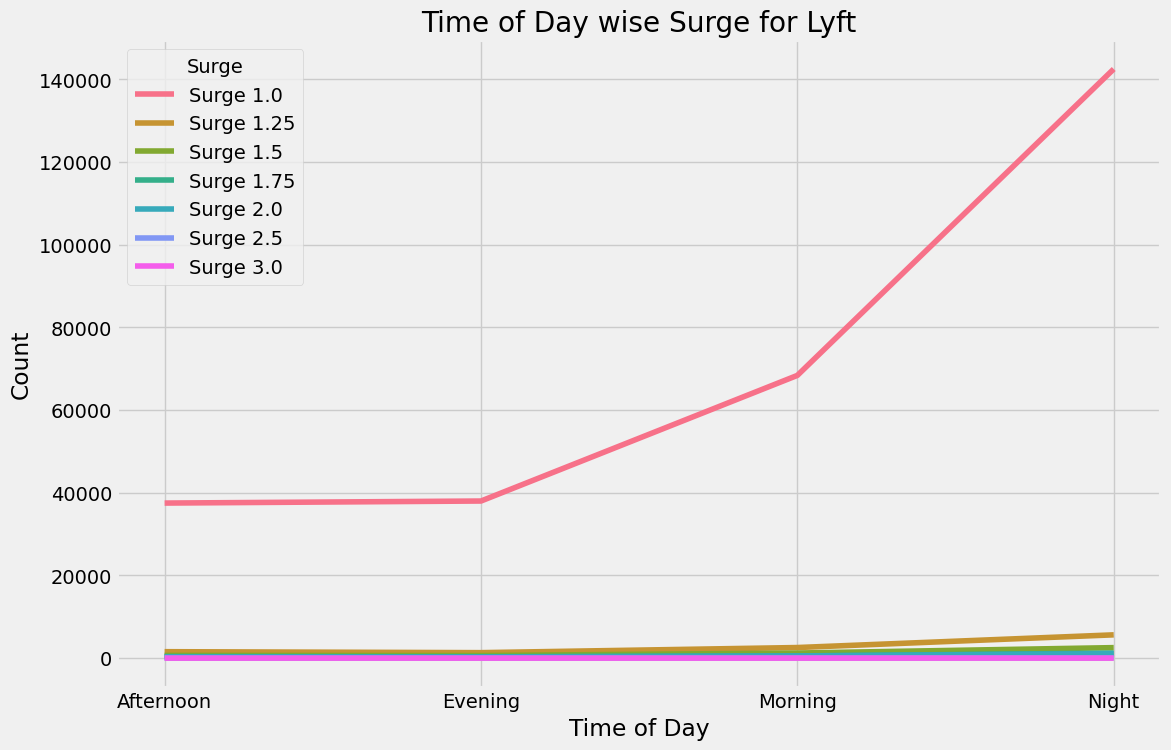

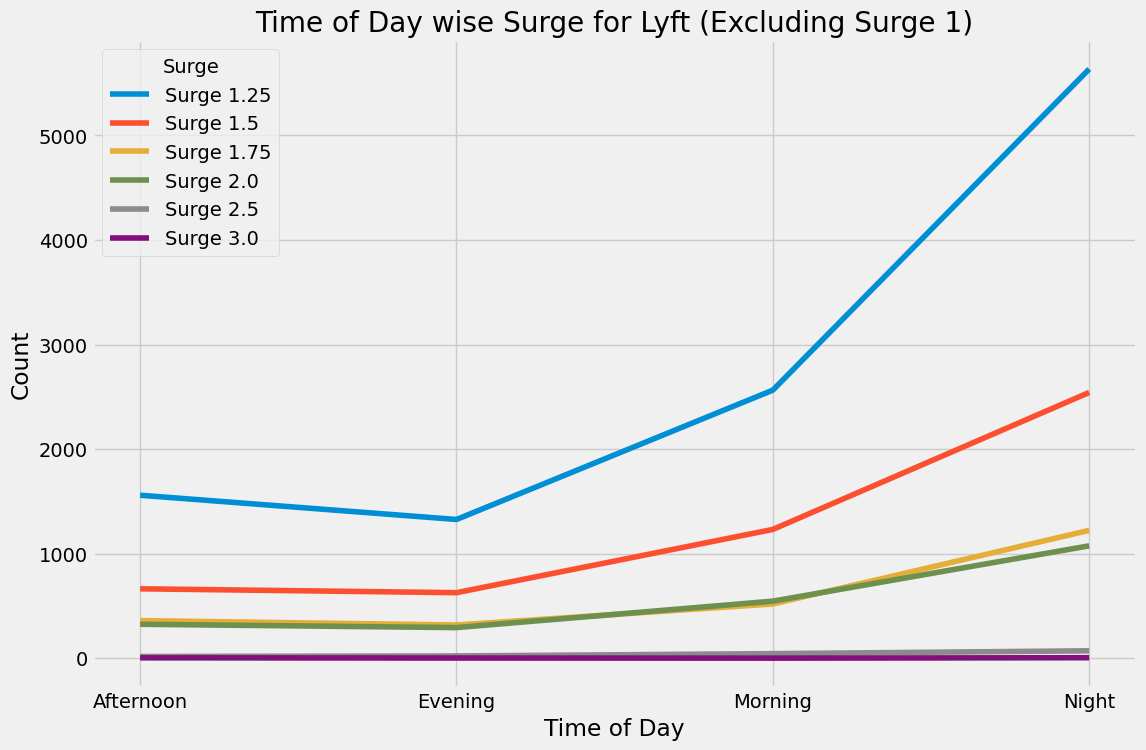

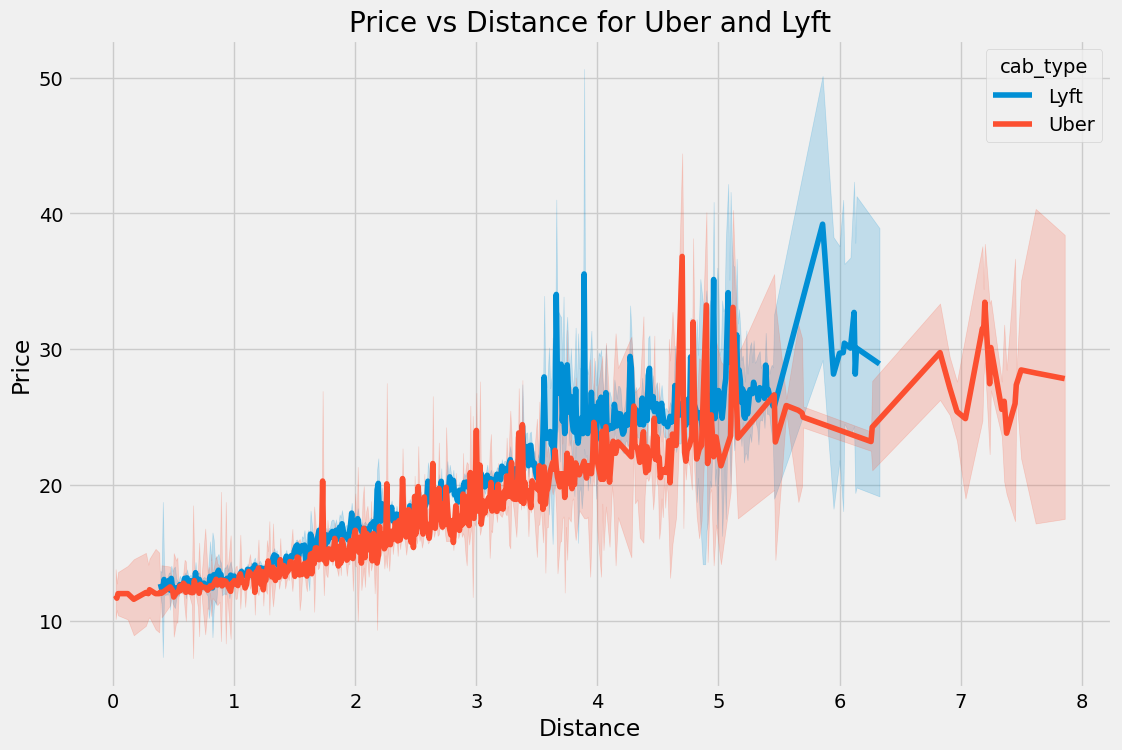

'\nInterpretation:\n\nUber is riders’ first choice irrespective of distance.'

In [108]:
# The line graph above illustrates the count of different surge multipliers for Lyft rides across various times of the day. Each surge multiplier category is represented by a different line,
## showing its frequency during morning, afternoon, evening, and night.
shared_rides = df[df['name'].str.contains('Shared', case=False)]
lyft_data = df[df['cab_type'] == 'Lyft']

def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 18:
        return 'Evening'
    else:
        return 'Night'

lyft_data['Time of Day'] = lyft_data['hour'].apply(assign_time_of_day)

surge_counts = lyft_data.groupby(['Time of Day', 'surge_multiplier']).size().reset_index(name='Count')
surge_counts['Surge'] = surge_counts['surge_multiplier'].apply(lambda x: 'Surge ' + str(x))

plt.figure(figsize=(12, 8))
sns.lineplot(x='Time of Day', y='Count', hue='Surge', data=surge_counts).set_title('Time of Day wise Surge for Lyft')
plt.show()

##The line graph now only includes instances where the surge multiplier was greater than one for Lyft rides,
# providing a clearer view of the surge pricing trends excluding the base fare times.

surge_counts_filtered = surge_counts[surge_counts['surge_multiplier'] != 1]

# Plotting the line graph for Lyft cab type data with surge multiplier values not equal to 1
plt.figure(figsize=(12, 8))
sns.lineplot(x='Time of Day', y='Count', hue='Surge', data=surge_counts_filtered).set_title('Time of Day wise Surge for Lyft (Excluding Surge 1)')
plt.show()

## Our understanding from the plot
'''
Interpretation:

Lyft’s Prime Timing happens the most during nighttime.
Morning rush hours also contribute to the surge.
A surge is less likely to happen during the afternoon and evening.'''

################################################################################################

# Plotting the line graph of price vs distance with lines indicating Uber and Lyft separately
plt.figure(figsize=(12, 8))
sns.lineplot(x='distance', y='price', hue='cab_type', data=df)
plt.title('Price vs Distance for Uber and Lyft')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.show()

'''
Interpretation:

Uber is riders’ first choice irrespective of distance.'''



<ipython-input-109-9192e035aff7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyft_data['Time of Day'] = lyft_data['hour'].apply(assign_time_of_day)


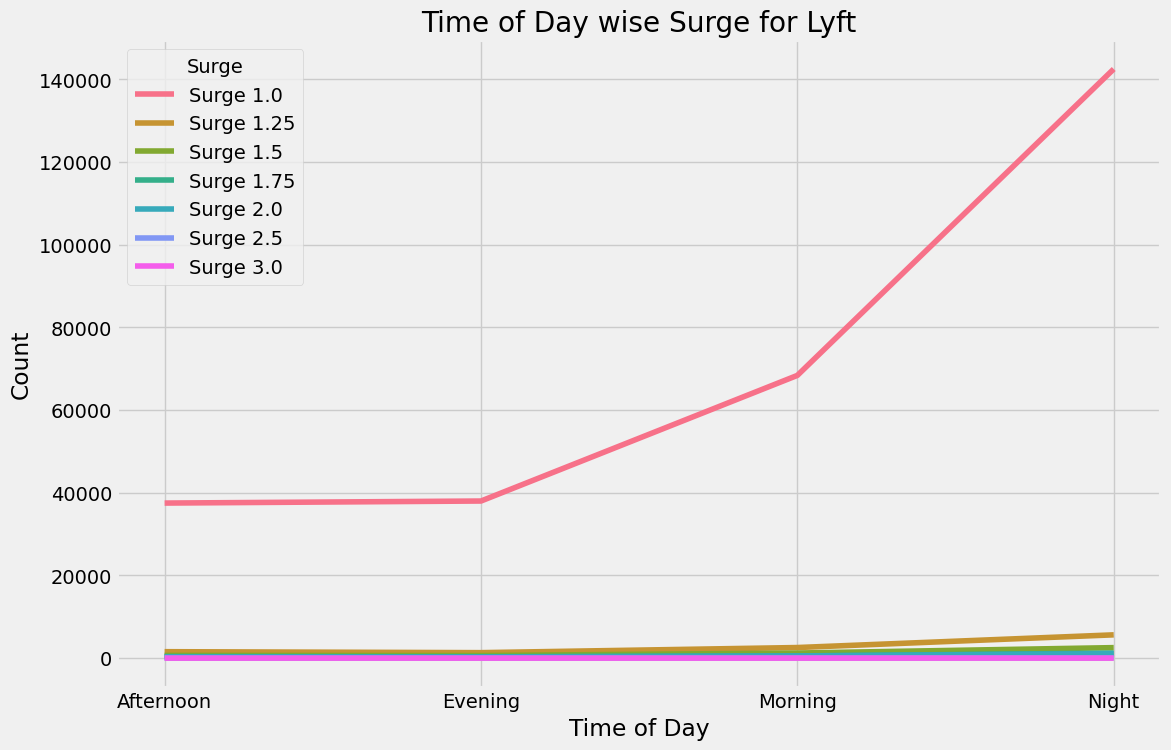

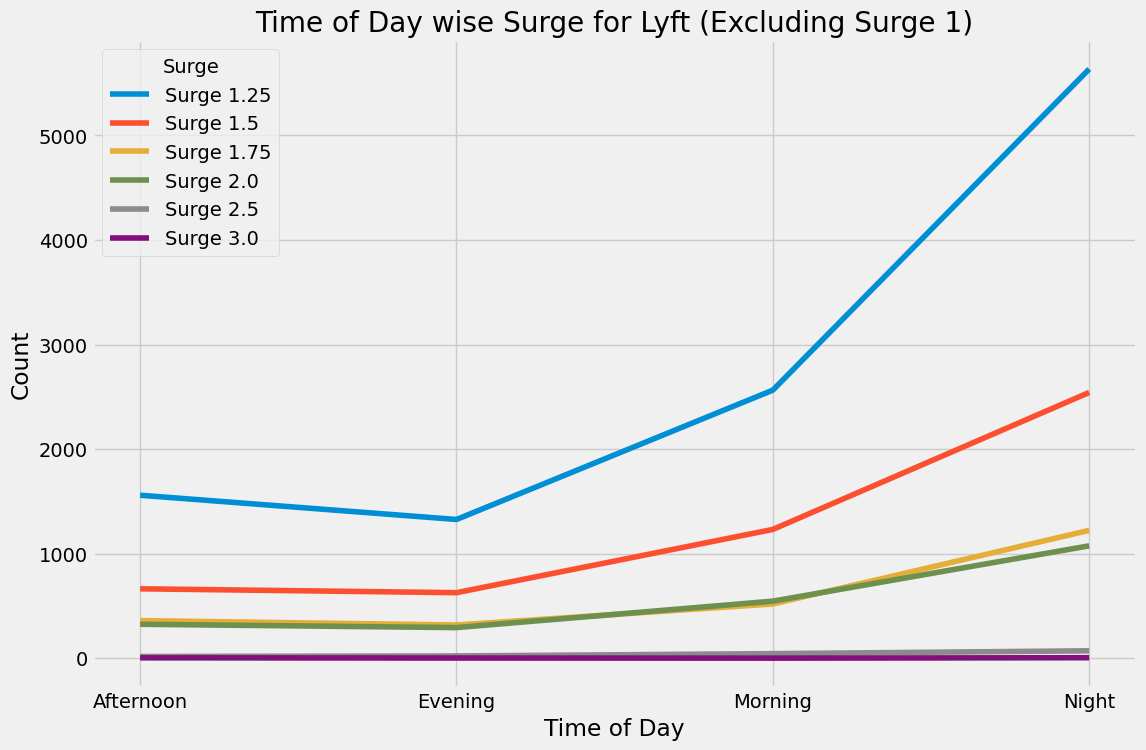

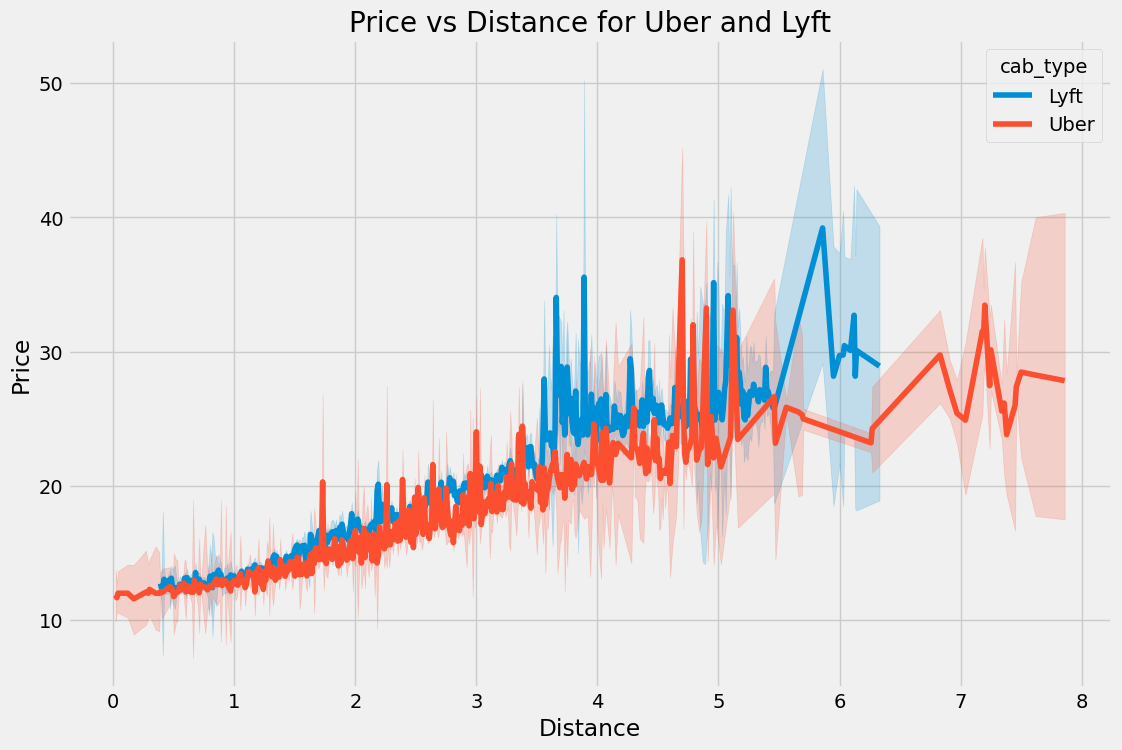

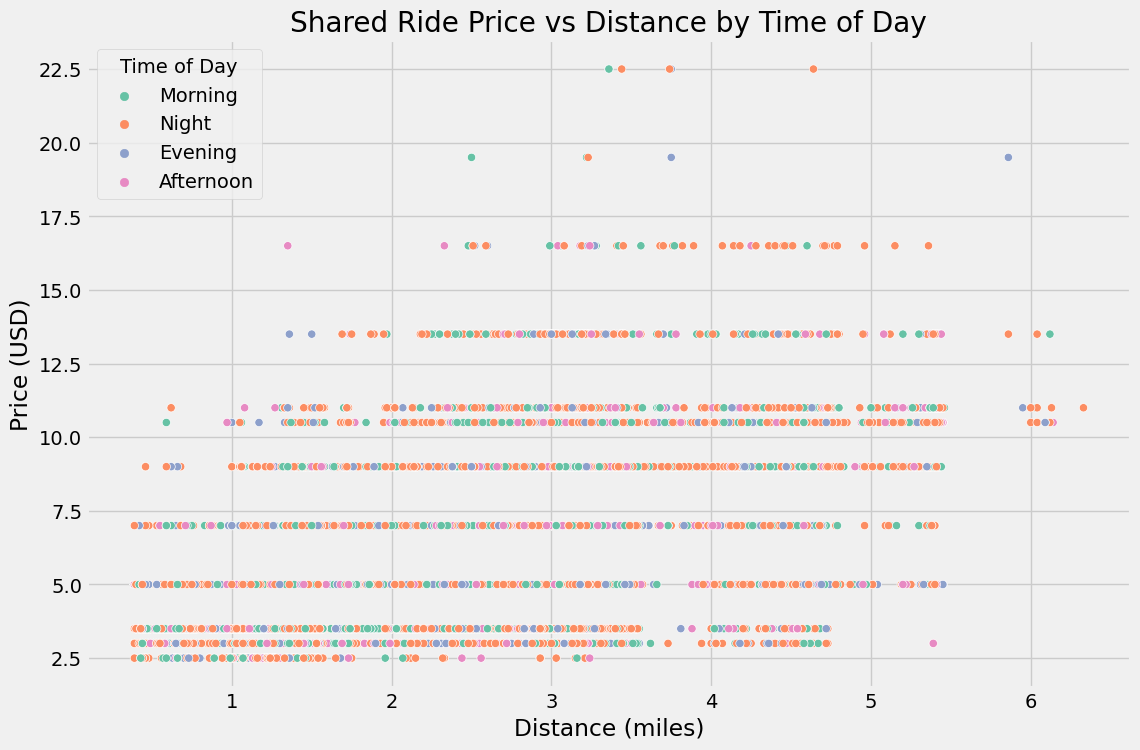

<ipython-input-109-9192e035aff7>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_rides['Time of Day'] = shared_rides['hour'].apply(assign_time_of_day)


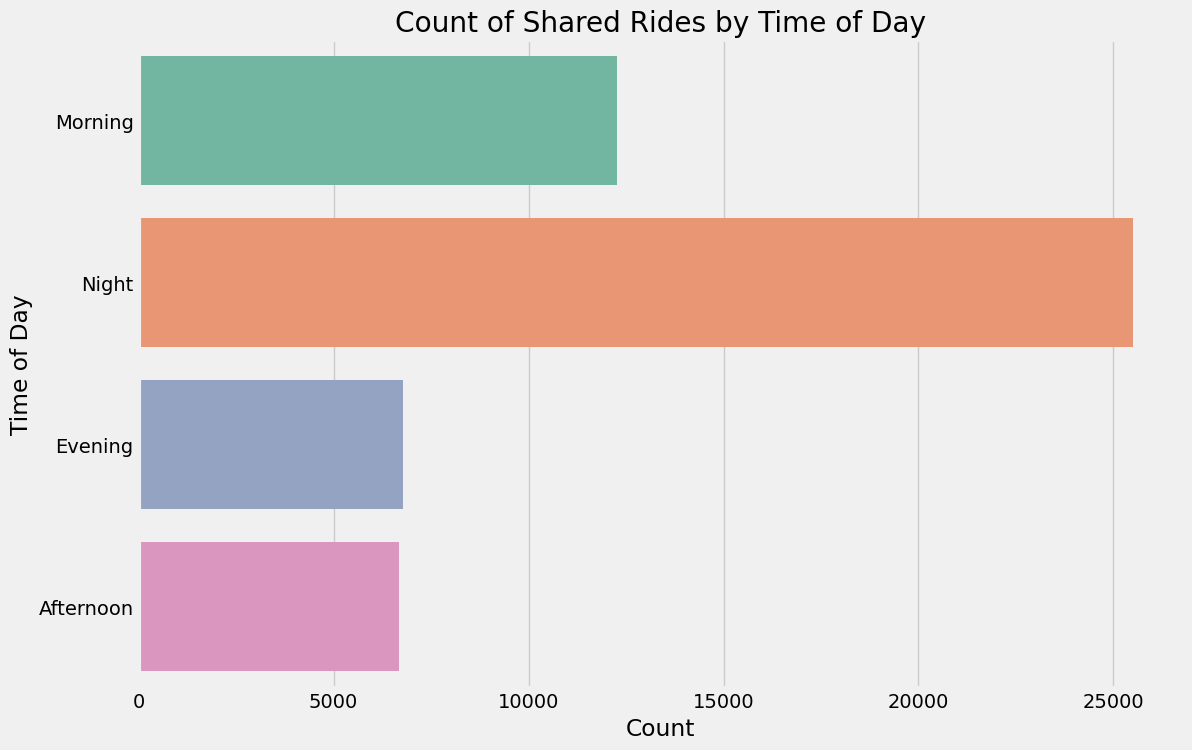

In [109]:
## showing its frequency during morning, afternoon, evening, and night.
shared_rides = df[df['name'].str.contains('Shared', case=False)]
lyft_data = df[df['cab_type'] == 'Lyft']

def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 18:
        return 'Evening'
    else:
        return 'Night'

lyft_data['Time of Day'] = lyft_data['hour'].apply(assign_time_of_day)

surge_counts = lyft_data.groupby(['Time of Day', 'surge_multiplier']).size().reset_index(name='Count')
surge_counts['Surge'] = surge_counts['surge_multiplier'].apply(lambda x: 'Surge ' + str(x))

plt.figure(figsize=(12, 8))
sns.lineplot(x='Time of Day', y='Count', hue='Surge', data=surge_counts).set_title('Time of Day wise Surge for Lyft')
plt.show()

##The line graph now only includes instances where the surge multiplier was greater than one for Lyft rides,
# providing a clearer view of the surge pricing trends excluding the base fare times.

surge_counts_filtered = surge_counts[surge_counts['surge_multiplier'] != 1]

# Plotting the line graph for Lyft cab type data with surge multiplier values not equal to 1
plt.figure(figsize=(12, 8))
sns.lineplot(x='Time of Day', y='Count', hue='Surge', data=surge_counts_filtered).set_title('Time of Day wise Surge for Lyft (Excluding Surge 1)')
plt.show()

## Our understanding from the plot
'''
Interpretation:

Lyft’s Prime Timing happens the most during nighttime.
Morning rush hours also contribute to the surge.
A surge is less likely to happen during the afternoon and evening.'''

################################################################################################

# Plotting the line graph of price vs distance with lines indicating Uber and Lyft separately
plt.figure(figsize=(12, 8))
sns.lineplot(x='distance', y='price', hue='cab_type', data=df)
plt.title('Price vs Distance for Uber and Lyft')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.show()

'''
Interpretation:

Uber is riders’ first choice irrespective of distance.'''


# Creating a scatterplot for shared rides with different colors indicating different times of day
plt.figure(figsize=(12, 8))
sns.scatterplot(x='distance', y='price', hue=lyft_data['Time of Day'], data=shared_rides, palette='Set2')
plt.title('Shared Ride Price vs Distance by Time of Day')
plt.xlabel('Distance (miles)')
plt.ylabel('Price (USD)')
plt.show()


'''Number of Shared Rides with Distance and Price

Interpretation:

1.People most likely have shared rides during the nighttime.
2.As the distance increases, the price also increases.
3.The number of shared rides is not growing with the increase in distance.
4.Apparently, people prefer to have shared rides for smaller distances.
People like taking shared rides over the courses of short passages, roughly lying between 1 to 3 kilometers.'''

#################################################################################################

#We can see average or mean of our price data in every route (source-destination) through table below

pd.set_option('display.max_rows', 72)
df.groupby(by=["source","destination"]).price.agg(["mean"])



shared_rides.shape
shared_rides['Time of Day'] = shared_rides['hour'].apply(assign_time_of_day)

# Creating a bar graph for the count of shared rides by time of day with the same shade of colors
plt.figure(figsize=(12, 8))
sns.countplot(y=shared_rides['Time of Day'], data=shared_rides, palette='Set2')
plt.title('Count of Shared Rides by Time of Day')
plt.ylabel('Time of Day')
plt.xlabel('Count')
plt.show()



In [110]:


# Calculate the distribution of Lyft and Uber rides over different sources and destinations
source_dest_distribution = rideshare_df.groupby(['source', 'destination', 'cab_type']).size().unstack()

# Display the distribution
source_dest_distribution

source_dest_distribution['Total'] = source_dest_distribution['Lyft'] + source_dest_distribution['Uber']
source_dest_distribution

cab_type                                         Lyft  Uber  Total
source                  destination                               
Back Bay                Boston University        4164  4518   8682
                        Fenway                   4212  4506   8718
                        Haymarket Square         4236  4602   8838
                        North End                4548  4866   9414
                        Northeastern University  4271  4554   8825
                        South Station            4224  4500   8724
Beacon Hill             Boston University        4098  4392   8490
                        Fenway                   4200  4488   8688
                        Haymarket Square         4218  4584   8802
                        North End                4446  4794   9240
                        Northeastern University  4302  4614   8916
                        South Station            4200  4505   8705
Boston University       Back Bay                 4164  4518   8682
                        Beacon Hill              4098  4386   8484
                        Financial District       4314  4626   8940
                        North Station            4230  4500   8730
                        Theatre District         4416  4758   9174
                        West End                 4398  4764   9162
Fenway                  Back Bay                 4212  4512   8724
                        Beacon Hill              4200  4488   8688
                        Financial District       4326  4590   8916
                        North Station            4284  4686   8970
                        Theatre District         4068  4440   8508
                        West End                 4530  4830   9360
Financial District      Boston University        4314  4626   8940
                        Fenway                   4326  4602   8928
                        Haymarket Square         4505  4824   9329
                        North End                4152  4446   8598
                        Northeastern University  4314  4554   8868
                        South Station            4626  4908   9534
Haymarket Square        Back Bay                 4236  4602   8838
                        Beacon Hill              4218  4584   8802
                        Financial District       4506  4824   9330
                        North Station            4314  4560   8874
                        Theatre District         4308  4571   8879
                        West End                 4032  4392   8424
North End               Back Bay                 4548  4866   9414
                        Beacon Hill              4446  4794   9240
                        Financial District       4152  4446   8598
                        North Station            4194  4481   8675
                        Theatre District         4170  4590   8760
                        West End                 4110  4374   8484
North Station           Boston University        4230  4500   8730
                        Fenway                   4284  4686   8970
                        Haymarket Square         4314  4566   8880
                        North End                4194  4480   8674
                        Northeastern University  4254  4650   8904
                        South Station            4050  4368   8418
Northeastern University Back Bay                 4266  4554   8820
                        Beacon Hill              4302  4618   8920
                        Financial District       4314  4560   8874
                        North Station            4254  4650   8904
                        Theatre District         4254  4620   8874
                        West End                 4224  4548   8772
South Station           Back Bay                 4224  4488   8712
                        Beacon Hill              4200  4506   8706
                        Financial District       4626  4908   9534
                        North Station          

# Let us drop date related features and store it in a separate dataframe.

In [163]:
new_df = df.drop(['id','timestamp','datetime','long_summary','apparentTemperatureHighTime','apparentTemperatureLowTime',
                  'apparentTemperatureLowTime','windGustTime','sunriseTime','sunsetTime','uvIndexTime','temperatureMinTime',
                 'temperatureMaxTime','apparentTemperatureMinTime','temperatureLowTime','apparentTemperatureMaxTime'],axis=1)

new_df.columns

Index(['hour', 'day', 'month', 'timezone', 'source', 'destination', 'cab_type',
       'product_id', 'name', 'price', 'distance', 'surge_multiplier',
       'latitude', 'longitude', 'temperature', 'apparentTemperature',
       'short_summary', 'precipIntensity', 'precipProbability', 'humidity',
       'windSpeed', 'windGust', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'apparentTemperatureHigh',
       'apparentTemperatureLow', 'icon', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'moonPhase', 'precipIntensityMax',
       'temperatureMin', 'temperatureMax', 'apparentTemperatureMin',
       'apparentTemperatureMax'],
      dtype='object')

In [113]:
temp_cols= ['temperature','apparentTemperature','temperatureHigh','temperatureLow','apparentTemperatureHigh',
                'apparentTemperatureLow','temperatureMin','temperatureHighTime','temperatureMax','apparentTemperatureMin','apparentTemperatureMax','price']

In [114]:
df_temp = new_df[temp_cols]
df_temp.head()

,temperature,apparentTemperature,temperatureHigh,temperatureLow,apparentTemperatureHigh,apparentTemperatureLow,temperatureMin,temperatureHighTime,temperatureMax,apparentTemperatureMin,apparentTemperatureMax,price
0,42.34,37.12,43.68,34.19,37.95,27.39,39.89,1544968800,43.68,33.73,38.07,5.0
1,43.58,37.35,47.30,42.10,43.92,36.20,40.49,1543251600,47.30,36.20,43.92,11.0
2,38.33,32.93,47.55,33.10,44.12,29.11,35.36,1543320000,47.55,31.04,44.12,7.0
3,34.38,29.63,45.03,28.90,38.53,26.20,34.67,1543510800,45.03,30.30,38.53,26.0
4,37.44,30.88,42.18,36.71,35.75,30.29,33.10,1543420800,42.18,29.11,35.75,9.0


<Axes: >

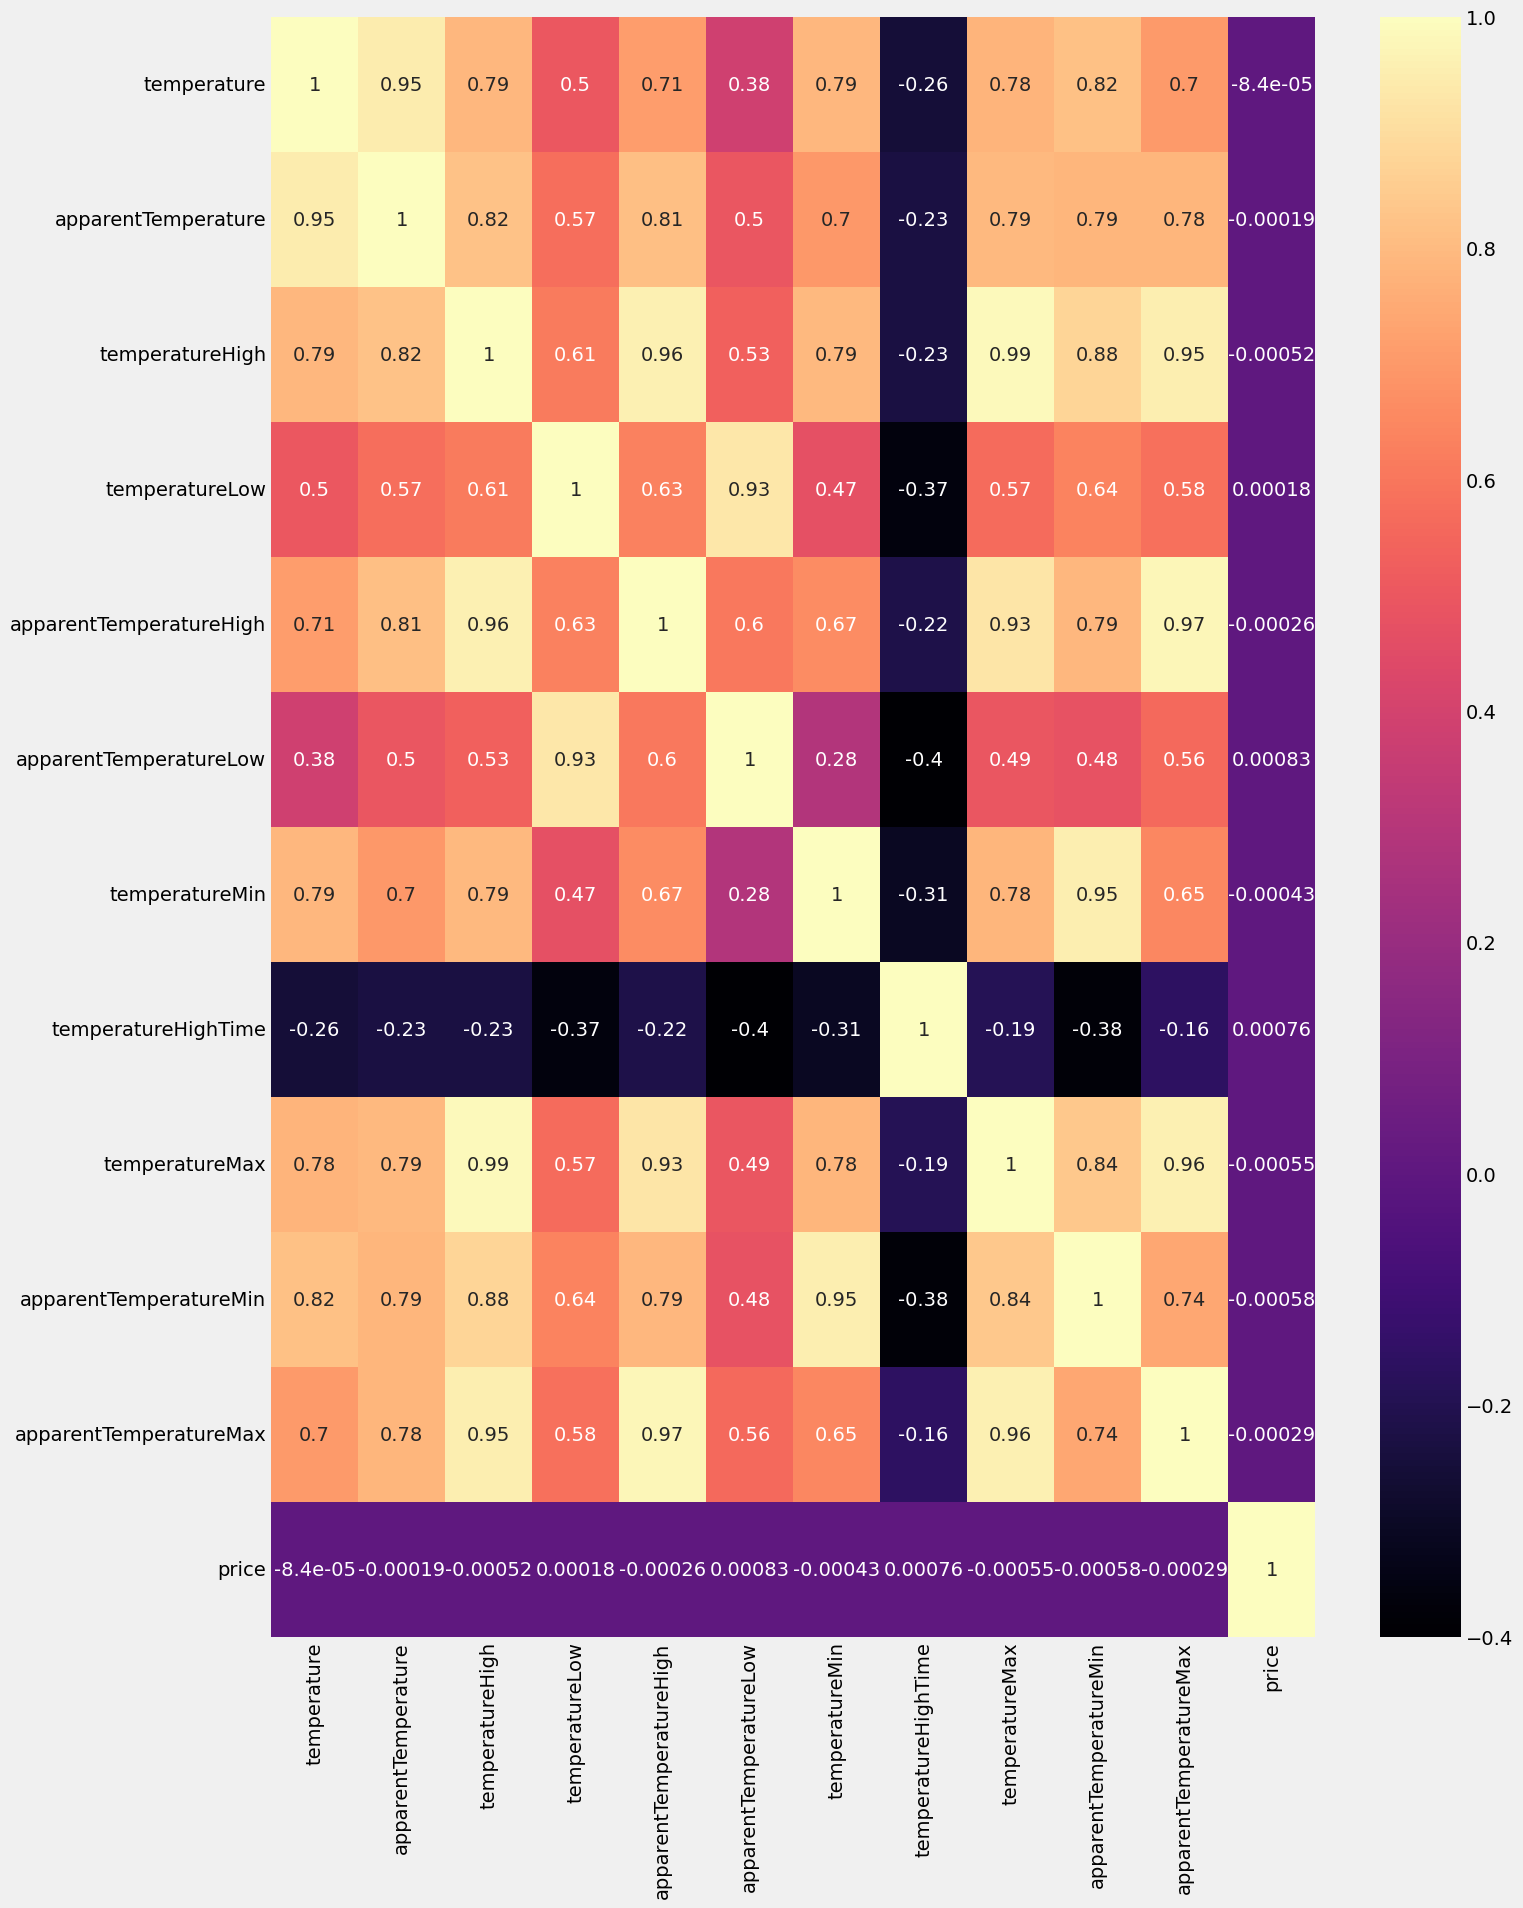

In [115]:
plt.figure(figsize=(15,20))
sns.heatmap(df_temp.corr(),annot=True,  cmap="magma")



We see that all temperature related features have weak correlation with our target feature which is price,
hence removing all of them will not make any impact to our regression model.

In [116]:
new_df = new_df.drop(['temperature','apparentTemperature','temperatureHigh','temperatureLow','apparentTemperatureHigh',
                'apparentTemperatureLow','temperatureMin','temperatureHighTime','temperatureMax','apparentTemperatureMin','apparentTemperatureMax'],axis=1)
new_df.shape

(637976, 30)

In [117]:
climate_column = ['precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'visibility', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'moonPhase',
       'precipIntensityMax','price']
df_clim = new_df[climate_column]
df_clim.head()

,precipIntensity,precipProbability,humidity,windSpeed,windGust,visibility,dewPoint,pressure,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,price
0,0.0000,0.0,0.68,8.66,9.17,10.000,32.70,1021.98,57,0.72,0,303.8,0.30,0.1276,5.0
1,0.1299,1.0,0.94,11.98,11.98,4.786,41.83,1003.97,90,1.00,0,291.1,0.64,0.1300,11.0
2,0.0000,0.0,0.75,7.33,7.33,10.000,31.10,992.28,240,0.03,0,315.7,0.68,0.1064,7.0
3,0.0000,0.0,0.73,5.28,5.28,10.000,26.64,1013.73,310,0.00,0,291.1,0.75,0.0000,26.0
4,0.0000,0.0,0.70,9.14,9.14,10.000,28.61,998.36,303,0.44,0,347.7,0.72,0.0001,9.0


<Axes: >

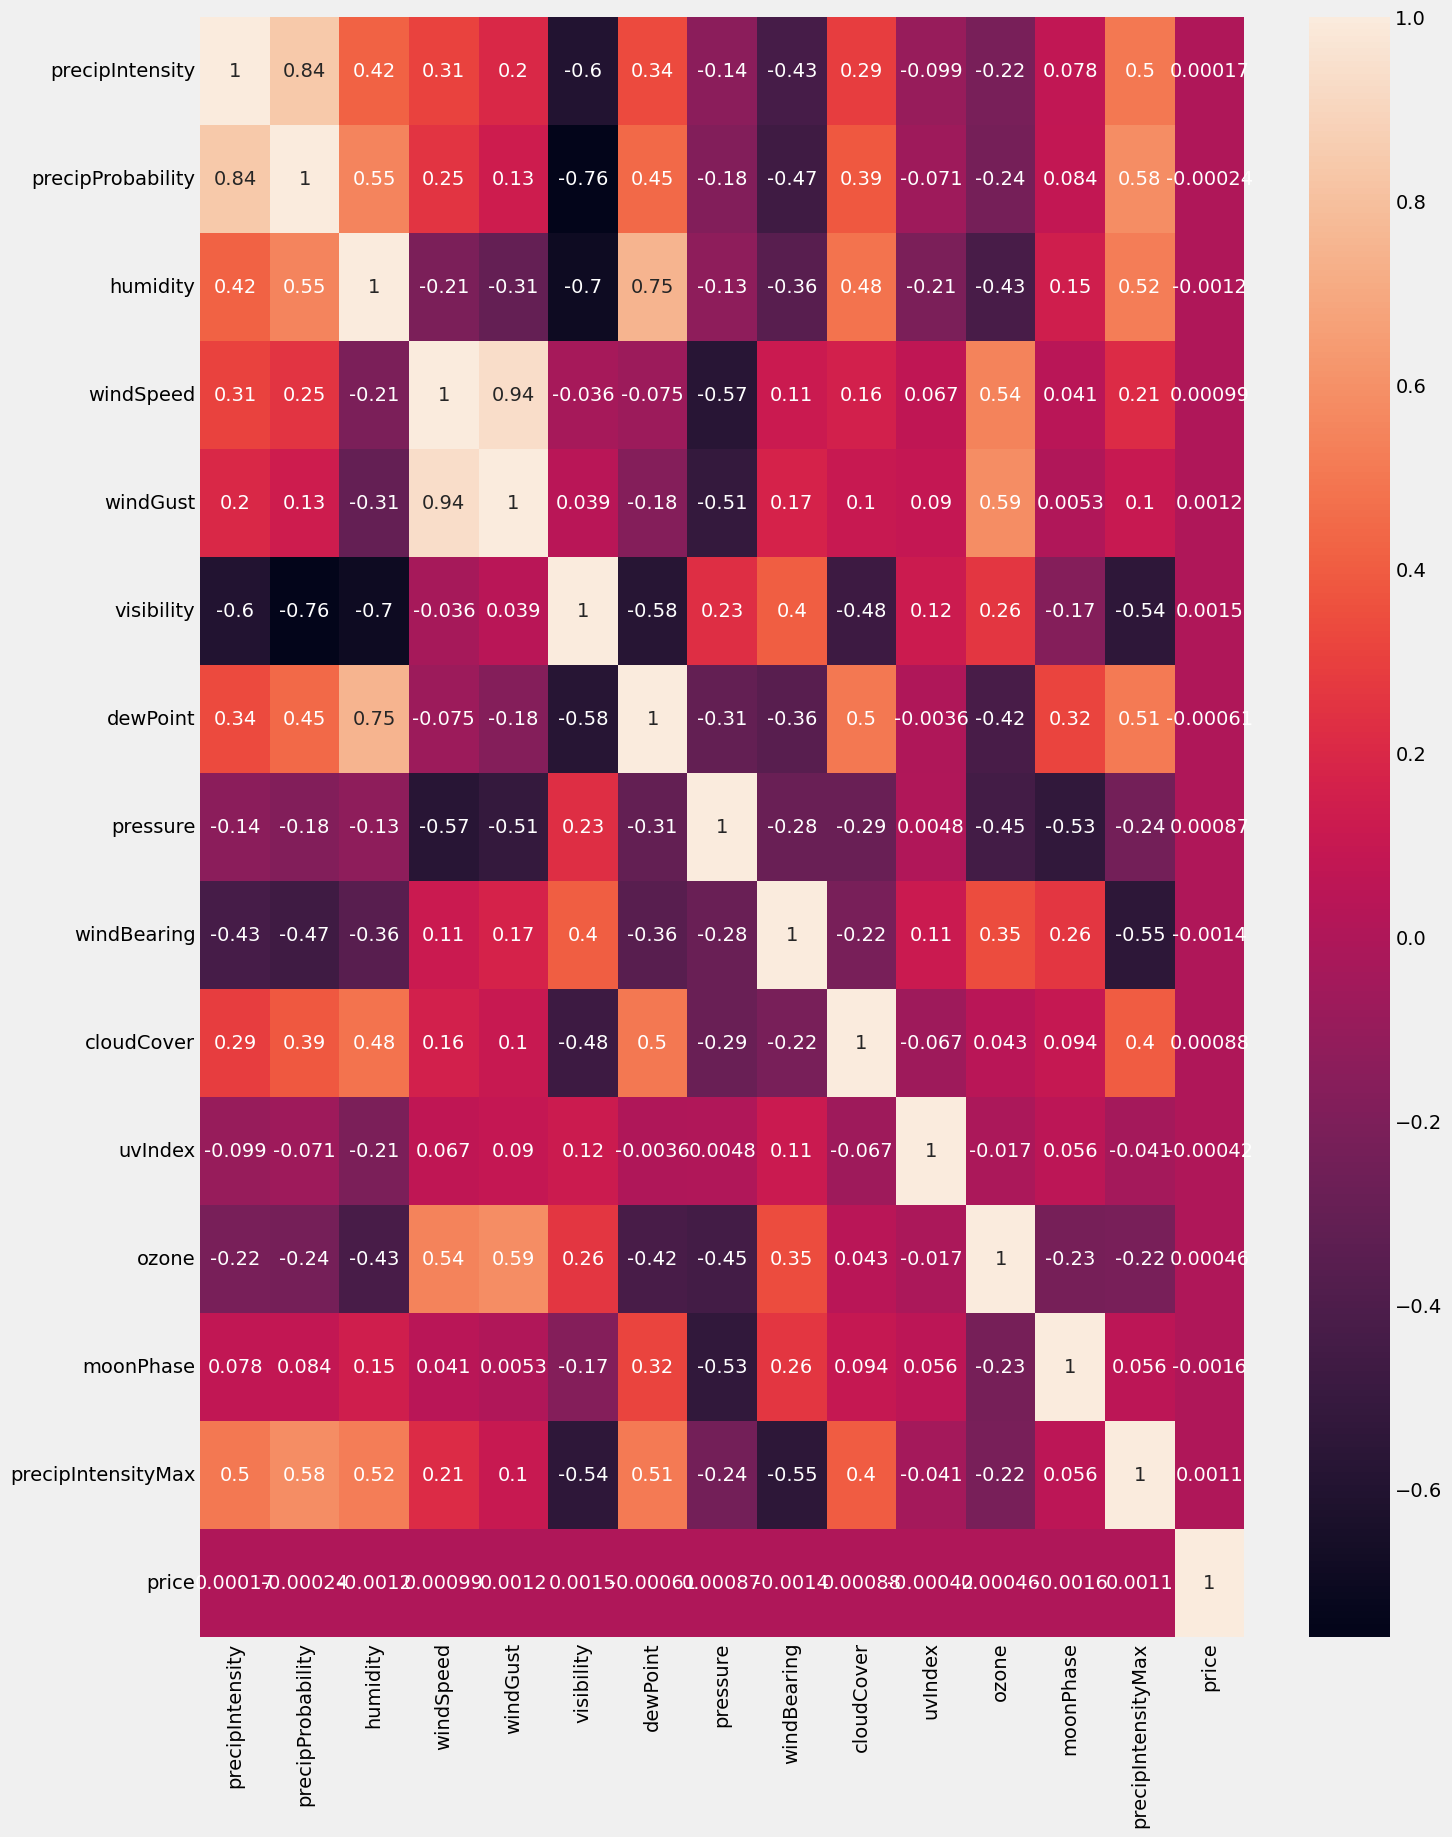

In [118]:
plt.figure(figsize=(15,20))
sns.heatmap(df_clim.corr(),annot=True)

All climate and weather related features also have weak correlation with our target feature which is price. These feature do not influence the price of the uber/lyft rides


In [119]:
new_df = new_df.drop(['precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'visibility', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'moonPhase',
       'precipIntensityMax'],axis=1)
new_df.shape

(637976, 16)

Checking for categorical features in the dataset

In [120]:
category_col = new_df.select_dtypes(include=['object','category']).columns.tolist()
for column in new_df[category_col]:
    print(f'{column} : {new_df[column].unique()}')
    print()

timezone : ['America/New_York']

source : ['Haymarket Square' 'Back Bay' 'North End' 'North Station' 'Beacon Hill'
 'Boston University' 'Fenway' 'South Station' 'Theatre District'
 'West End' 'Financial District' 'Northeastern University']

destination : ['North Station' 'Northeastern University' 'West End' 'Haymarket Square'
 'South Station' 'Fenway' 'Theatre District' 'Beacon Hill' 'Back Bay'
 'North End' 'Financial District' 'Boston University']

cab_type : ['Lyft' 'Uber']

product_id : ['lyft_line' 'lyft_premier' 'lyft' 'lyft_luxsuv' 'lyft_plus' 'lyft_lux'
 '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'
 '6c84fd89-3f11-4782-9b50-97c468b19529'
 '55c66225-fbe7-4fd5-9072-eab1ece5e23e'
 '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'
 '6d318bcc-22a3-4af6-bddd-b409bfce1546'
 '997acbb5-e102-41e1-b155-9df7de0a73f2']

name : ['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool']

short_summary : [' Mostly Cloudy ' ' Rain ' ' Clear ' ' Partly Clou

We can see that 'timezone' feature has only 1 value and 'product_id' feature contains many unidentified values. So we can remove or drop them.

In [121]:
new_df = new_df.drop(['timezone','product_id'],axis=1)

In [160]:
new_df.columns

Index(['cab_type', 'name', 'price', 'distance', 'surge_multiplier'], dtype='object')

Fourth, i want to check the correlation of our categorical features with our target feature (price)

In [123]:
new_cat = ['source',
 'destination',
 'cab_type',
 'name',
 'short_summary',
 'icon','price']

df_cat = new_df[new_cat]
df_cat.head()



,source,destination,cab_type,name,short_summary,icon,price
0,Haymarket Square,North Station,Lyft,Shared,Mostly Cloudy,partly-cloudy-night,5.0
1,Haymarket Square,North Station,Lyft,Lux,Rain,rain,11.0
2,Haymarket Square,North Station,Lyft,Lyft,Clear,clear-night,7.0
3,Haymarket Square,North Station,Lyft,Lux Black XL,Clear,clear-night,26.0
4,Haymarket Square,North Station,Lyft,Lyft XL,Partly Cloudy,partly-cloudy-night,9.0


Convert to these categorical columns to one-hot encoding

In [124]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_cat_encode= df_cat.copy()
for col in df_cat_encode.select_dtypes(include='O').columns:
    df_cat_encode[col]=le.fit_transform(df_cat_encode[col])


df_cat_encode


,source,destination,cab_type,name,short_summary,icon,price
0,5,7,0,7,4,5,5.0
1,5,7,0,2,8,6,11.0
2,5,7,0,5,0,1,7.0
3,5,7,0,4,0,1,26.0
4,5,7,0,6,6,5,9.0
...,...,...,...,...,...,...,...
693065,11,6,1,11,6,5,9.5
693066,11,6,1,10,6,5,13.0
693067,11,6,1,9,6,5,9.5
693069,11,6,1,1,6,5,27.0


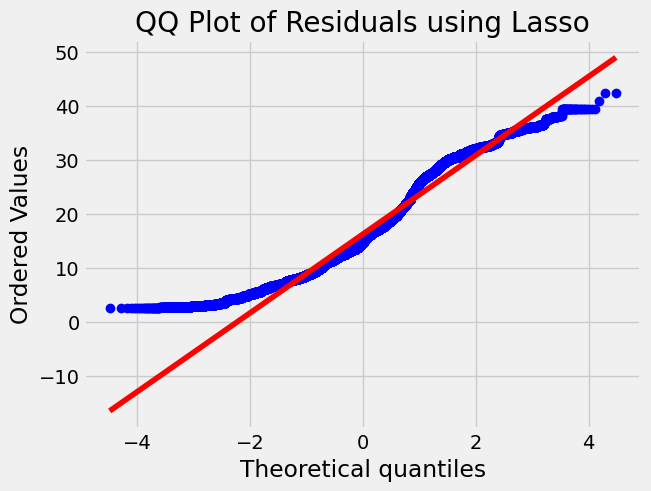

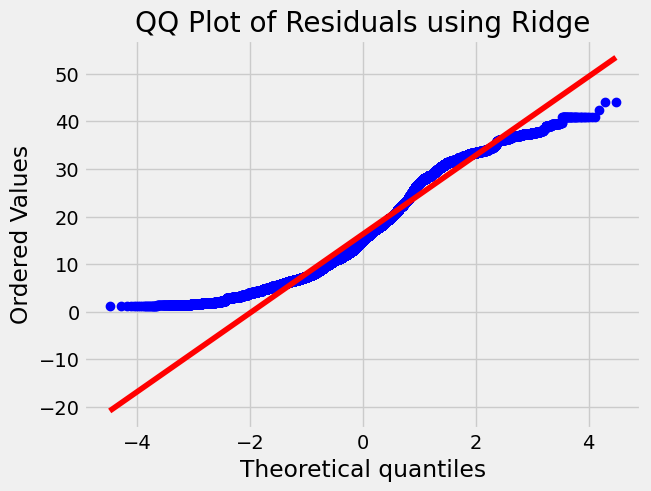

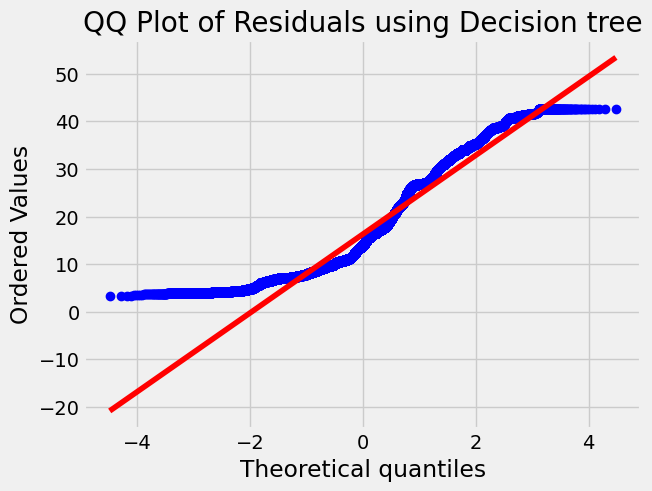

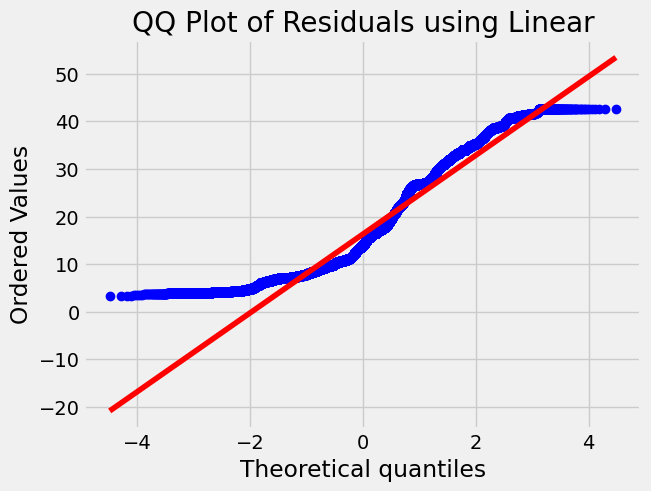

In [155]:

plt.style.use("fivethirtyeight")


names = ["Lasso", "Ridge", "Decision tree","Linear"]
for i, (name, test) in enumerate(zip(names, y_red_tests)):
  # with plt.style.context("dark_background"):
    probplot(test, dist='norm', plot=plt)
    plt.title(f'QQ Plot of Residuals using {name}')
    plt.show()

<Axes: >

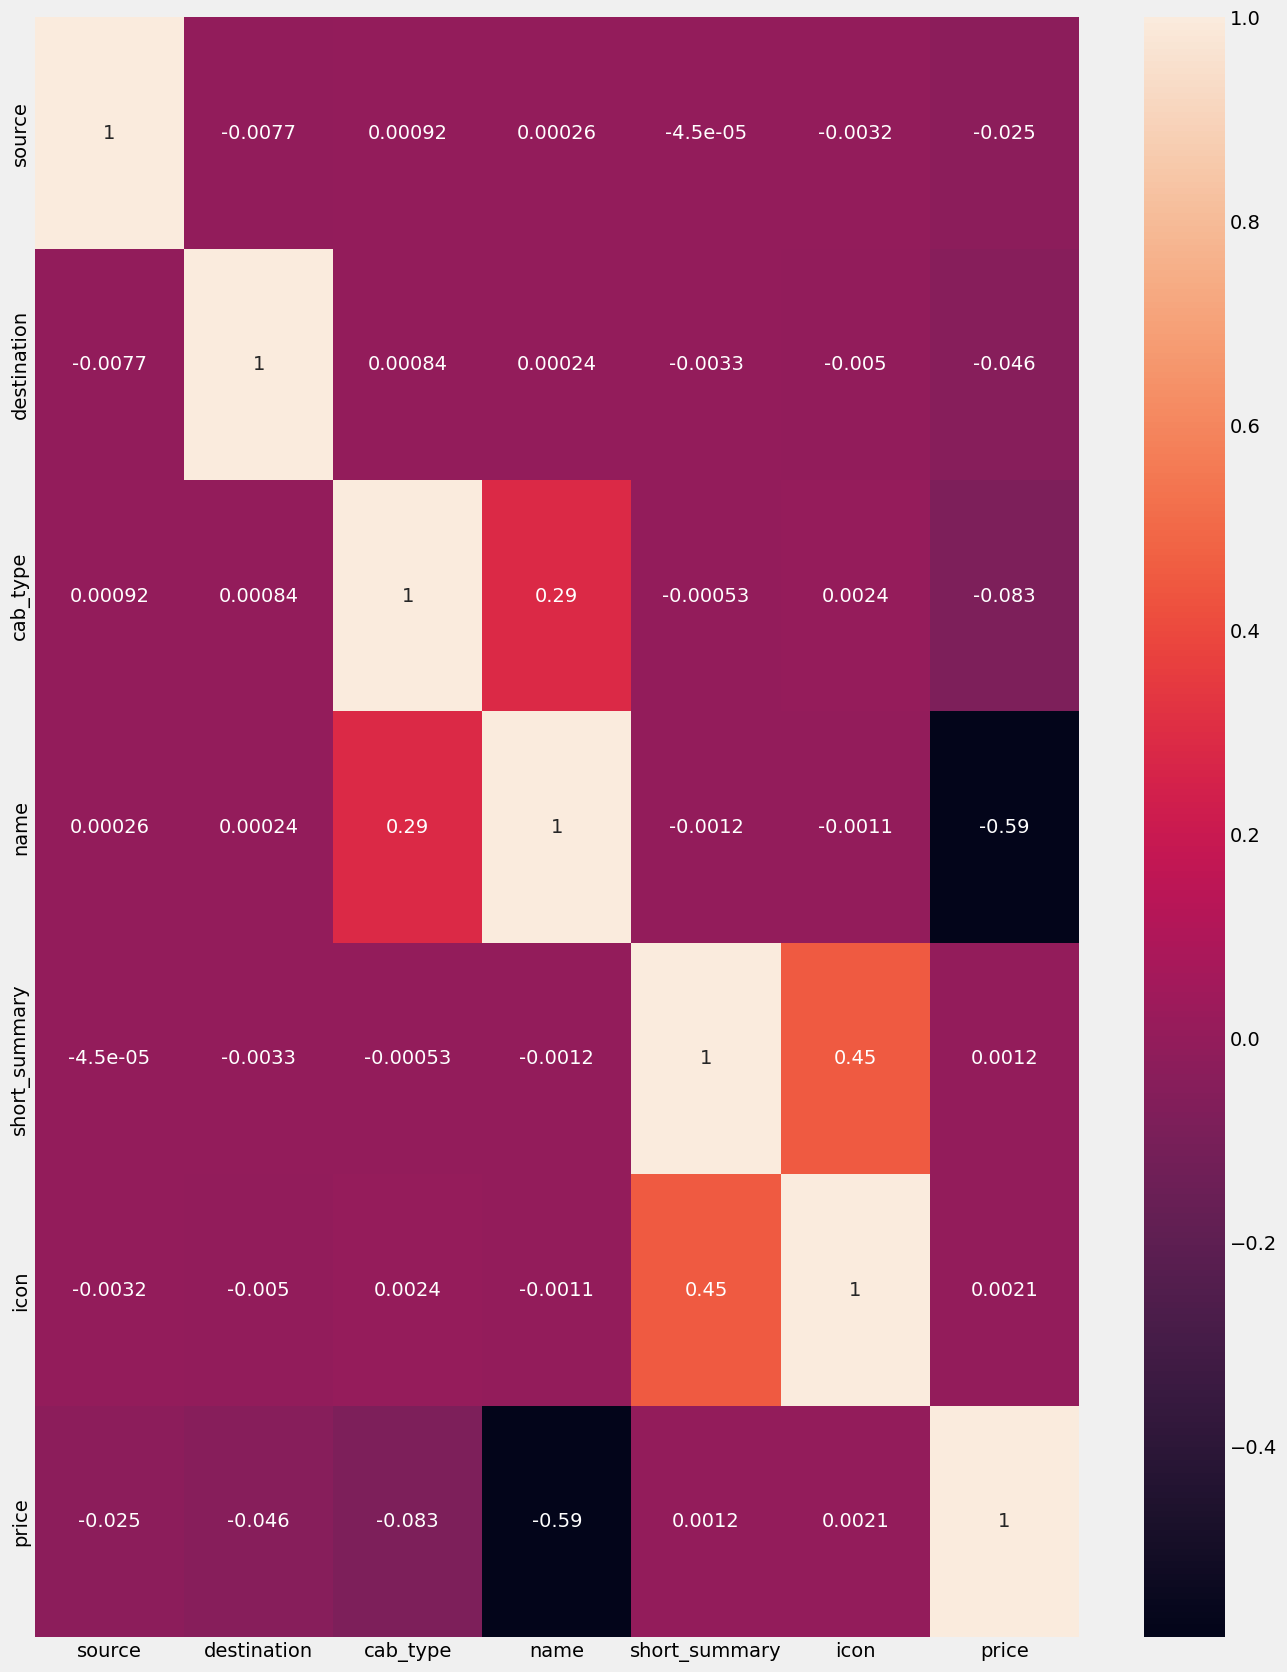

In [156]:
plt.figure(figsize=(15,20))
sns.heatmap(df_cat_encode.corr(),annot=True)

We can see only name feature that has a relatively strong correlation. Source,destination, and cab_type features have relatively weak correlation, but i will pick cab_type feature because it has stronger correlation than other two features. I will drop or remove the rest of the columns

In [164]:
new_df.head()

,hour,day,month,timezone,source,destination,cab_type,product_id,name,price,...,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
0,9,16,12,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,...,57,0.72,0,303.8,0.30,0.1276,39.89,43.68,33.73,38.07
1,2,27,11,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,...,90,1.00,0,291.1,0.64,0.1300,40.49,47.30,36.20,43.92
2,1,28,11,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,...,240,0.03,0,315.7,0.68,0.1064,35.36,47.55,31.04,44.12
3,4,30,11,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,...,310,0.00,0,291.1,0.75,0.0000,34.67,45.03,30.30,38.53
4,3,29,11,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,...,303,0.44,0,347.7,0.72,0.0001,33.10,42.18,29.11,35.75


In [165]:
new_exxpl = ['hour',
 'day', 'month',
 'cab_type',
 'name',
 'price']

df_exxpl = new_df[new_exxpl]
df_exxpl.head()

df_exxpl_encode= df_exxpl.copy()
for col in df_exxpl_encode.select_dtypes(include='O').columns:
    df_exxpl_encode[col]=le.fit_transform(df_exxpl_encode[col])

<Axes: >

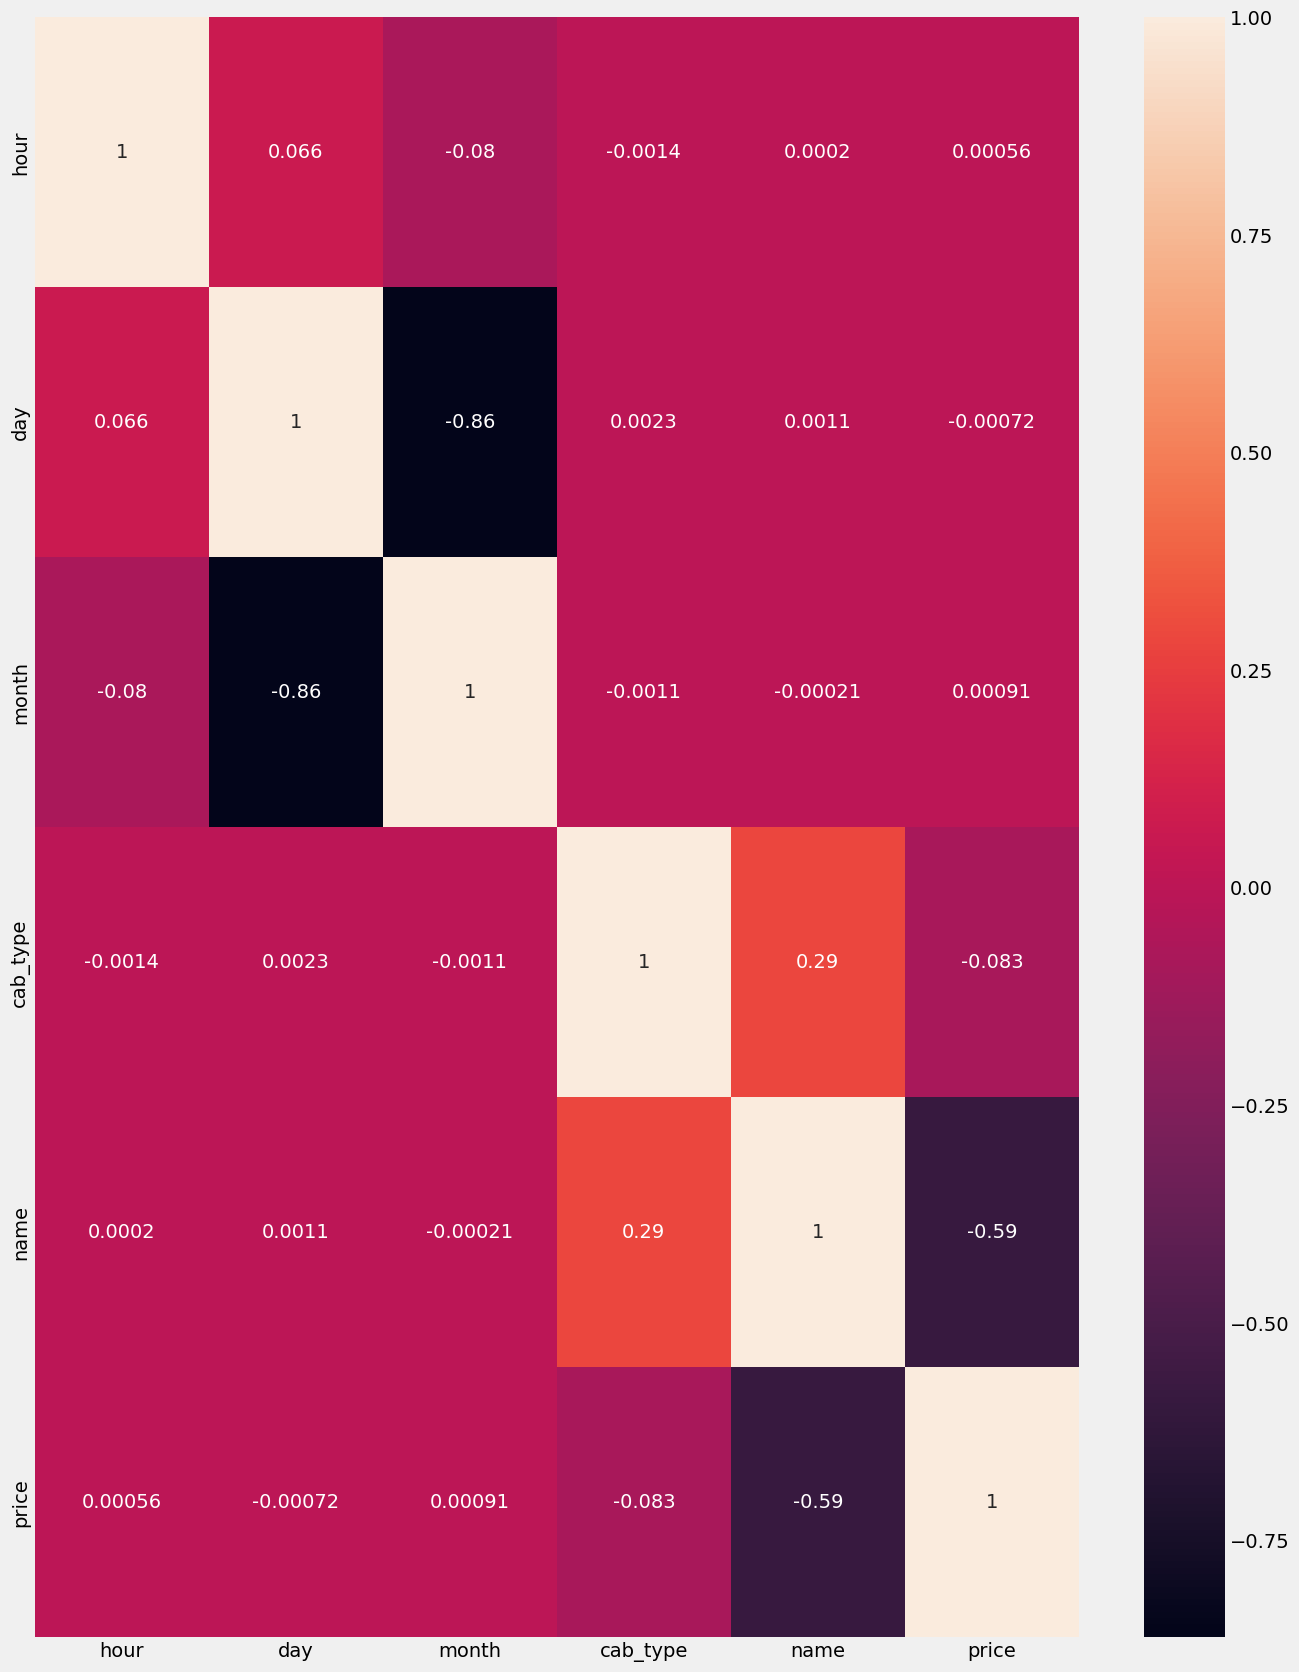

In [166]:
plt.figure(figsize=(15,20))

sns.heatmap(df_exxpl_encode.corr(),annot=True )


Also i will remove hour, day, month, latitude, longitude, because we won't need them for now

In [167]:
new_df = new_df.drop(['hour','day','month','latitude','longitude'],axis=1)
new_df.head()


,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,temperature,...,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
0,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,0.44,1.0,42.34,...,57,0.72,0,303.8,0.30,0.1276,39.89,43.68,33.73,38.07
1,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,0.44,1.0,43.58,...,90,1.00,0,291.1,0.64,0.1300,40.49,47.30,36.20,43.92
2,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,0.44,1.0,38.33,...,240,0.03,0,315.7,0.68,0.1064,35.36,47.55,31.04,44.12
3,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,0.44,1.0,34.38,...,310,0.00,0,291.1,0.75,0.0000,34.67,45.03,30.30,38.53
4,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,0.44,1.0,37.44,...,303,0.44,0,347.7,0.72,0.0001,33.10,42.18,29.11,35.75


In [168]:
new_df.columns

Index(['timezone', 'source', 'destination', 'cab_type', 'product_id', 'name',
       'price', 'distance', 'surge_multiplier', 'temperature',
       'apparentTemperature', 'short_summary', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust', 'visibility',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'apparentTemperatureHigh', 'apparentTemperatureLow', 'icon', 'dewPoint',
       'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'ozone',
       'moonPhase', 'precipIntensityMax', 'temperatureMin', 'temperatureMax',
       'apparentTemperatureMin', 'apparentTemperatureMax'],
      dtype='object')

#### Removing Outliers using IQR method for checking top and bottom outliers

In [169]:
Qp12 = new_df['price'].quantile(0.25)
Qp32 = new_df['price'].quantile(0.75)


IQRp = Qp32-Qp12
print("Qp12 ", Qp12)
print("Qp32 ", Qp32)
print("IQRp ", IQRp)


new_df

Qp12  9.0
Qp32  22.5
IQRp  13.5


,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,temperature,...,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
0,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,0.44,1.0,42.34,...,57,0.72,0,303.8,0.30,0.1276,39.89,43.68,33.73,38.07
1,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,0.44,1.0,43.58,...,90,1.00,0,291.1,0.64,0.1300,40.49,47.30,36.20,43.92
2,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,0.44,1.0,38.33,...,240,0.03,0,315.7,0.68,0.1064,35.36,47.55,31.04,44.12
3,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,0.44,1.0,34.38,...,310,0.00,0,291.1,0.75,0.0000,34.67,45.03,30.30,38.53
4,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,0.44,1.0,37.44,...,303,0.44,0,347.7,0.72,0.0001,33.10,42.18,29.11,35.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693065,America/New_York,West End,North End,Uber,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,9.5,1.00,1.0,37.05,...,133,0.31,0,271.5,0.82,0.0000,31.42,44.76,27.77,44.09
693066,America/New_York,West End,North End,Uber,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,13.0,1.00,1.0,37.05,...,133,0.31,0,271.5,0.82,0.0000,31.42,44.76,27.77,44.09
693067,America/New_York,West End,North End,Uber,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,9.5,1.00,1.0,37.05,...,133,0.31,0,271.5,0.82,0.0000,31.42,44.76,27.77,44.09
693069,America/New_York,West End,North End,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,27.0,1.00,1.0,37.05,...,133,0.31,0,271.5,0.82,0.0000,31.42,44.76,27.77,44.09


In [170]:
new_df[new_df['price']>(Qp32+(1.5*IQRp))]


,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,temperature,...,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
706,America/New_York,South Station,Back Bay,Lyft,lyft_lux,Lux Black,52.5,3.25,2.00,34.40,...,259,0.48,0,344.7,0.72,0.0000,33.75,42.60,29.97,36.58
707,America/New_York,South Station,Back Bay,Lyft,lyft_luxsuv,Lux Black XL,67.5,3.25,2.00,40.87,...,36,0.14,0,296.6,0.27,0.0082,39.74,54.29,37.04,53.62
769,America/New_York,Theatre District,Boston University,Lyft,lyft_luxsuv,Lux Black XL,45.5,4.76,1.00,44.89,...,167,0.16,1,289.1,0.24,0.0000,26.93,46.68,27.58,43.98
1094,America/New_York,Theatre District,Fenway,Lyft,lyft_luxsuv,Lux Black XL,45.5,4.31,1.00,46.78,...,120,1.00,1,280.3,0.86,0.0916,36.32,50.80,35.84,50.13
1318,America/New_York,Financial District,Boston University,Lyft,lyft_luxsuv,Lux Black XL,45.5,5.33,1.00,42.42,...,76,1.00,1,326.7,0.30,0.1246,38.94,43.78,33.76,38.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692439,America/New_York,Financial District,Boston University,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,47.0,5.56,1.00,40.40,...,286,0.77,0,350.3,0.33,0.0184,34.25,41.35,28.40,35.88
692698,America/New_York,Financial District,Fenway,Lyft,lyft_luxsuv,Lux Black XL,52.5,4.58,1.25,27.71,...,148,0.14,0,294.7,0.24,0.0000,27.05,46.67,24.47,43.88
692891,America/New_York,Financial District,Boston University,Lyft,lyft_luxsuv,Lux Black XL,47.5,5.42,1.00,45.78,...,276,1.00,0,289.6,0.89,0.0004,42.83,57.52,39.65,56.85
692962,America/New_York,Back Bay,North End,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,51.0,7.36,1.00,36.95,...,151,0.80,0,271.7,0.82,0.0000,31.55,44.72,27.95,44.05


In [171]:
new_df[new_df['price']<(Qp12-(1.5*IQRp))]

,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,temperature,...,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax


In [172]:
print('Size before removing :',new_df.shape)
new_df= new_df[~((new_df['price']>(Qp32+(1.5*IQRp))))]
print('Size after removing :',new_df.shape)

Size before removing : (637976, 36)
Size after removing : (632387, 36)


In [173]:
def one_hot_encoder(data,feature,keep_first=True):

    one_hot_cols = pd.get_dummies(data[feature])

    for col in one_hot_cols.columns:
        one_hot_cols.rename({col:f'{feature}_'+col},axis=1,inplace=True)

    new_data = pd.concat([data,one_hot_cols],axis=1)
    new_data.drop(feature,axis=1,inplace=True)

    if keep_first == False:
        new_data=new_data.iloc[:,1:]

    return new_data

In [174]:
new_df_onehot=new_df.copy()
for col in new_df_onehot.select_dtypes(include = 'O').columns:
    new_df_onehot=one_hot_encoder(new_df_onehot,col)

new_df_onehot.head()


# new_df['cab_type'].unique().sum()


# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
# data = enc.fit_transform(new_df[['cab_type','name']])






,price,distance,surge_multiplier,temperature,apparentTemperature,precipIntensity,precipProbability,humidity,windSpeed,windGust,...,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,5.0,0.44,1.0,42.34,37.12,0.0000,0.0,0.68,8.66,9.17,...,0,0,0,0,0,0,0,0,1,0
1,11.0,0.44,1.0,43.58,37.35,0.1299,1.0,0.94,11.98,11.98,...,0,0,1,0,0,0,0,0,0,1
2,7.0,0.44,1.0,38.33,32.93,0.0000,0.0,0.75,7.33,7.33,...,0,0,0,0,1,0,0,0,0,0
3,26.0,0.44,1.0,34.38,29.63,0.0000,0.0,0.73,5.28,5.28,...,0,0,0,0,1,0,0,0,0,0
4,9.0,0.44,1.0,37.44,30.88,0.0000,0.0,0.70,9.14,9.14,...,1,0,0,0,0,0,0,0,1,0


In [175]:
x = new_df_onehot.drop(columns=['price'],axis=1).values
y = new_df_onehot['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
new_df_onehot




,price,distance,surge_multiplier,temperature,apparentTemperature,precipIntensity,precipProbability,humidity,windSpeed,windGust,...,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain,icon_ clear-day,icon_ clear-night,icon_ cloudy,icon_ fog,icon_ partly-cloudy-day,icon_ partly-cloudy-night,icon_ rain
0,5.0,0.44,1.0,42.34,37.12,0.0000,0.0,0.68,8.66,9.17,...,0,0,0,0,0,0,0,0,1,0
1,11.0,0.44,1.0,43.58,37.35,0.1299,1.0,0.94,11.98,11.98,...,0,0,1,0,0,0,0,0,0,1
2,7.0,0.44,1.0,38.33,32.93,0.0000,0.0,0.75,7.33,7.33,...,0,0,0,0,1,0,0,0,0,0
3,26.0,0.44,1.0,34.38,29.63,0.0000,0.0,0.73,5.28,5.28,...,0,0,0,0,1,0,0,0,0,0
4,9.0,0.44,1.0,37.44,30.88,0.0000,0.0,0.70,9.14,9.14,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693065,9.5,1.00,1.0,37.05,37.05,0.0000,0.0,0.74,2.34,2.87,...,1,0,0,0,0,0,0,0,1,0
693066,13.0,1.00,1.0,37.05,37.05,0.0000,0.0,0.74,2.34,2.87,...,1,0,0,0,0,0,0,0,1,0
693067,9.5,1.00,1.0,37.05,37.05,0.0000,0.0,0.74,2.34,2.87,...,1,0,0,0,0,0,0,0,1,0
693069,27.0,1.00,1.0,37.05,37.05,0.0000,0.0,0.74,2.34,2.87,...,1,0,0,0,0,0,0,0,1,0


Creating the model on the basis of features chosen using VIF

In [176]:
#Selected the data based on the VIF values

vif_data
print("vif shape", vif_data.shape) #NOTE: This is a data without outliers so we will not need to remove the outliers


#Converting the data to one hot encoding
vif_data_onehot=vif_data.copy()
vif_data_onehot.dtypes
for col in vif_data_onehot.select_dtypes(include = 'object').columns:
    vif_data_onehot =one_hot_encoder(vif_data_onehot,col)

#diffrentiate between the x and y
x_vif = vif_data_onehot.drop(columns=['price'],axis=1).values
y_vif = vif_data_onehot['price']

#dividing into test and train model
X_train_vif, X_test_vif, y_train_vif, y_test_vif = train_test_split(x_vif, y_vif, test_size=0.3, random_state=0)
new_df_onehot

# fitting the regression model
reg_vif = LinearRegression()
model_vif = reg_vif.fit(X_train_vif,y_train_vif)
y_pred_vif = model_vif.predict(X_test_vif)

print("R2 score: ", str(r2_score(y_test_vif, y_pred_vif)))


vif shape (637976, 11)
R2 score:  0.9281050176599771


The R2

## Running bootstrap for linear regression using resampling the data


```
# This is formatted as code
```



In [177]:


# Initialize the models
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)
decision_tree = DecisionTreeRegressor(random_state=42)
linear = LinearRegression()

# Fit the models
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
linear.fit(X_train,y_train)


# Predict on the test set
y_pred_lasso = lasso.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_decision_tree = decision_tree.predict(X_test)
y_pred_linear = decision_tree.predict(X_test)


y_red_tests  = [y_pred_lasso, y_pred_ridge, y_pred_decision_tree, y_pred_linear]

# Calculate the performance metrics for each model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_decision_tree = mean_squared_error(y_test, y_pred_decision_tree)
r2_decision_tree = r2_score(y_test, y_pred_decision_tree)


mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Output the performance metrics for each model
performance_metrics = {
    'Lasso': {'MSE': mse_lasso, 'R2': r2_lasso},
    'Ridge': {'MSE': mse_ridge, 'R2': r2_ridge},
    'Decision Tree': {'MSE': mse_decision_tree, 'R2': r2_decision_tree},
    'Linear': {'MSE': mse_linear, 'R2': r2_linear}
}





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.58715e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [178]:
bootstrap_regressor = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)

# Fit the model on the training data
bootstrap_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = bootstrap_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

KeyboardInterrupt: ignored

In [ ]:
r2_bootstrap = r2_score(y_test, y_pred)
r2_bootstrap

In [ ]:


# Define the hypotheses for Uber vs Lyft price comparison
# Null Hypothesis (H0): There is no difference in average prices between Uber and Lyft
# Alternative Hypothesis (H1): There is a difference in average prices between Uber and Lyft
uber_prices = df[df['cab_type'] == 'Uber']['price'].dropna()
lyft_prices = df[df['cab_type'] == 'Lyft']['price'].dropna()
price_ttest_result = stats.ttest_ind(uber_prices, lyft_prices, equal_var=False)

# Define the hypotheses for the costliness of 'SUV Black'
# We will compare 'SUV Black' to all other services
suv_black_prices = df[df['name'] == 'Black SUV']['price'].dropna()
other_services_prices = df[df['name'] != 'Black SUV']['price'].dropna()
suv_black_ttest_result = stats.ttest_ind(suv_black_prices, other_services_prices, equal_var=False)

# Define the hypotheses for the relationship between distance and price
# We will use Pearson correlation to test the hypothesis


price_distance_corr = stats.pearsonr(new_df['distance'], new_df['price'])



# Output the results
print('T-test result for Uber vs Lyft prices:', price_ttest_result)
print('T-test result for Lux Black XL costliness:', suv_black_ttest_result)
# print('Pearson correlation between distance and price:', price_distance_corr)




Null Hypothesis (H0): Lux Black XL service is the costliest

Alternative Hypothesis (H1): Lux Black XL service is not the costliest

T-test result for Lux Black XL costliness: TtestResult(statistic=641.072256252032, df=91875.59856838667)


In [ ]:
#Do longer distances result in a higher price per unit distance due to pricing tiers or minimum fare thresholds?
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm

tqdm.pandas()

# Assuming 'df' is the dataframe and it has 'distance' and 'price' columns
# We will calculate the price per unit distance and perform a linear regression

# Calculate price per unit distance
new_df['price_per_unit_distance'] = df['price'] / df['distance']


# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(new_df['distance'], new_df['price_per_unit_distance'])

# Output the results and the decision on the hypothesis
print('Hypothesis for the relationship between distance and price per unit distance:')
print('Null Hypothesis (H0): There is no relationship between distance and price per unit distance.')
print('Alternative Hypothesis (H1): There is a relationship between distance and price per unit distance.')
print('\nLinear Regression Results:')
print(f'Slope: {slope}')
print(f'Intercept: {intercept}')
print(f'R-squared: {r_value**2}')
print(f'Standard Error: {std_err}')

# Hypothesis decision
if p_value < 0.05:
    print('\nThe null hypothesis is rejected in favor of the alternative hypothesis.')
    print('There is a statistically significant relationship between distance and price per unit distance.')
else:
    print('\nThe null hypothesis cannot be rejected.')
    print('There is no statistically significant relationship between distance and price per unit distance.')